# Makemore part 3 -> Pytorchify the network

Implement the makemore part 3 lecture last few portions in Pytorch version using different classes

## Step 1: Create the dataset

In [1]:
# Read the file names.txt and store each line as a list in the variable names
with open('names.txt', 'r') as file:
    names = file.readlines()

# Remove any trailing newline characters from each name
names = [name.strip() for name in names]

# Print the length of the list
print(len(names))

32033


In [2]:
import random

def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    # Ensure the ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1"
    
    # Set the seed for reproducibility
    random.seed(seed)
    
    # Shuffle the dataset
    random.shuffle(dataset)
    
    # Calculate the split indices
    train_end = int(train_ratio * len(dataset))
    val_end = train_end + int(val_ratio * len(dataset))
    
    # Split the dataset
    train_set = dataset[:train_end]
    val_set = dataset[train_end:val_end]
    test_set = dataset[val_end:]
    
    return train_set, val_set, test_set

# Split the names list
train_names, val_names, test_names = split_dataset(names)

# Print the lengths of the splits
print(f"Train set size: {len(train_names)}")
print(f"Validation set size: {len(val_names)}")
print(f"Test set size: {len(test_names)}")

Train set size: 25626
Validation set size: 3203
Test set size: 3204


In [3]:
chars = sorted(list(set("".join(name for name in names))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [4]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, char in enumerate(chars):
    stoi[char] = i + 1
    itos[i + 1] = char

len(stoi), len(itos)

(27, 27)

In [15]:
import torch

def create_dataset(names, window_size=3):
    # Create a list to hold the input sequences
    X, y = [], []
    
    # Iterate over each name in the dataset
    for name in names:
        # Pad the name with spaces on either side
        padded_name = ['.'] * window_size + list(name) + ['.']
        
        # Create the input-output pairs
        for i in range(len(name) + 1):
            # Extract the input and output sequences
            input_seq = padded_name[i:i+window_size]
            output_seq = padded_name[i+window_size]
            
            # Convert the input and output characters to their corresponding indices
            X.append([stoi[char] for char in input_seq])
            y.append(stoi[output_seq])
            
            
    # Convert the input-output pairs to PyTorch tensors
    X = torch.LongTensor(X)
    y = torch.LongTensor(y)

    return X, y

In [16]:
X_train, y_train = create_dataset(train_names)
X_val, y_val = create_dataset(val_names)
X_test, y_test = create_dataset(test_names)

In [17]:
X_train.shape, y_train.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [18]:
X_val.shape, y_val.shape

(torch.Size([22655, 3]), torch.Size([22655]))

In [19]:
X_test.shape, y_test.shape

(torch.Size([22866, 3]), torch.Size([22866]))

## Step 2: Create individual layers of the model in torch-like class format

### Linear

In [33]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True, generator=None):
        # Initialize the weights and biases
        self.weights = torch.randn(fan_in, fan_out, generator=generator) * 1 / ((fan_in)**0.50)
        self.bias = bias
        if self.bias:
            self.biases = torch.zeros(fan_out)
        
    def __call__(self, x):
        # Compute the output
        self.out =  x @ self.weights # Use self.out to track the activations for later use
        if self.bias:
            self.out += self.biases
        return self.out
    
    def params(self):
        # Return the weights and biases
        return [self.weights] + ([self.biases] if self.bias else [])

### BatchNorm1d

In [366]:
class BatchNorm1d:
    def __init__(self, num_features, momentum=0.1, epsilon=1e-5):
        # Initialize the scale and shift parameters
        self.scale = torch.ones(num_features).float()
        self.shift = torch.zeros(num_features).float()
        self.training = True
        # Initialize the running mean and variance
        self.momentum = momentum
        self.epsilon = epsilon
        self.running_mean = torch.zeros(num_features).float()
        self.running_var = torch.ones(num_features).float()
        
    def __call__(self, x):
        # Check if the network is in training mode
        if self.training:
            # Compute the mean and variance
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, keepdim=True)
        else:
            # Use the running mean and variance for inference
            mean = self.running_mean
            var = self.running_var
            
        # Normalize the input
        x_normalized = (x - mean) / torch.sqrt(var + self.epsilon)
        
        # Scale and shift
        self.out = self.scale * x_normalized + self.shift

        # Update the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        return self.out
    
    def params(self):
        # Return the scale and shift parameters
        return [self.scale, self.shift]

### Tanh

In [35]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def params(self):
        return []

## Step 3: Create the network and the training loop

In [284]:
def create_model(vocab_size, block_size, emb_dim, hidden_dim):
    g = torch.Generator().manual_seed(2147483647)

    # create embeddimg matrix
    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

    # build the full network
    # layers = [
    #     Linear(emb_dim * block_size, hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
    #     Linear(hidden_dim , hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
    #     Linear(hidden_dim , hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
    #     Linear(hidden_dim , vocab_size)
    # ]

    layers = [
        Linear(emb_dim * block_size, hidden_dim, generator=g, bias=False), Tanh(),
        Linear(hidden_dim , hidden_dim, generator=g, bias=False), Tanh(),
        Linear(hidden_dim , hidden_dim, generator=g, bias=False), Tanh(),
        Linear(hidden_dim , hidden_dim, generator=g, bias=False), Tanh(),
        Linear(hidden_dim , hidden_dim, generator=g, bias=False), Tanh(),
        Linear(hidden_dim , vocab_size)
    ]

    with torch.no_grad():
        # Make last layer activations bit unconfident
        layers[-1].weights.data *= 0.1

        # Do Kaiming init for the remaning layers
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weights.data *= 5/3

    params = [C] + [param for layer in layers for param in layer.params()]

    for p in params:
        p.requires_grad = True

    print(f"No. of parameters = {sum(p.numel() for p in params)}")

    return params, layers

In [285]:
params_nobn, layers_nobn = create_model(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi))

No. of parameters = 663097


In [368]:
def train(params, layers, X, y, num_iters, learning_rate_schedule, batch_size):
    stepi, lossi, ud = [], [], []

    for i in range(num_iters):
        # Sample a random batch of inputs and targets
        idx = torch.randint(0, len(X), (batch_size,))
        X_batch, y_batch = X[idx], y[idx]

        # Forward pass
        emb = params[0][X_batch]
        h = emb.view(X_batch.shape[0], -1)
        for layer in layers:
            h = layer(h)
        logits = h

        # Compute the cross-entropy loss
        loss = torch.nn.functional.cross_entropy(logits, y_batch)

        # DEBUG --> reatin gradients of the out
        # for layer in layers:
        #     layer.out.retain_grad()

        # Set the gradeints of parameters to None
        for param in params:
            param.grad = None
            
        # Backward pass
        loss.backward()

        #Update the parameters
        with torch.no_grad():
            for param in params:
                param -= learning_rate_schedule(i) * param.grad

        # Log the loss value
        stepi.append(i)
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([(learning_rate_schedule(i) * param.grad.std() / param.std()).log10().item() for param in params])

        if i % 10000 == 0:
            print(f"Step {i}, Loss {loss.item()}")  

    ud = torch.tensor(ud).float()
    return stepi, lossi, ud

## Step 4: Do iterations for a bit of time (say 1000 iterations), observe activations, gradients etc

In [ ]:
stepi, lossi, ud= train(learning_rate_schedule=lambda i: (10**(-1.95)) if i < 100000 else (10**(-1.95)),\
                            num_iters=1000, params=params_nobn, layers=layers_nobn,\
                                X=X_train, y=y_train, batch_size=128)

# stepi, lossi, ud= train(learning_rate_schedule=lambda i: 0.001,\
#                             num_iters=1000, params=params_nobn, layers=layers_nobn,\
#                                 X=X_train, y=y_train, batch_size=128)

Step 0, Loss 3.2958014011383057


### No BatchNorm

### Plot 1: Activations of the tanh layer plotted as a histogram

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Plot if the Kaiming gain of 5/3 is used

Layer 1: Tanh, Mean: 0.03, Std: 0.75, Saturations: 19.45
Layer 3: Tanh, Mean: -0.00, Std: 0.71, Saturations: 11.54
Layer 5: Tanh, Mean: -0.02, Std: 0.72, Saturations: 10.85
Layer 7: Tanh, Mean: 0.00, Std: 0.72, Saturations: 9.55
Layer 9: Tanh, Mean: 0.00, Std: 0.67, Saturations: 7.23


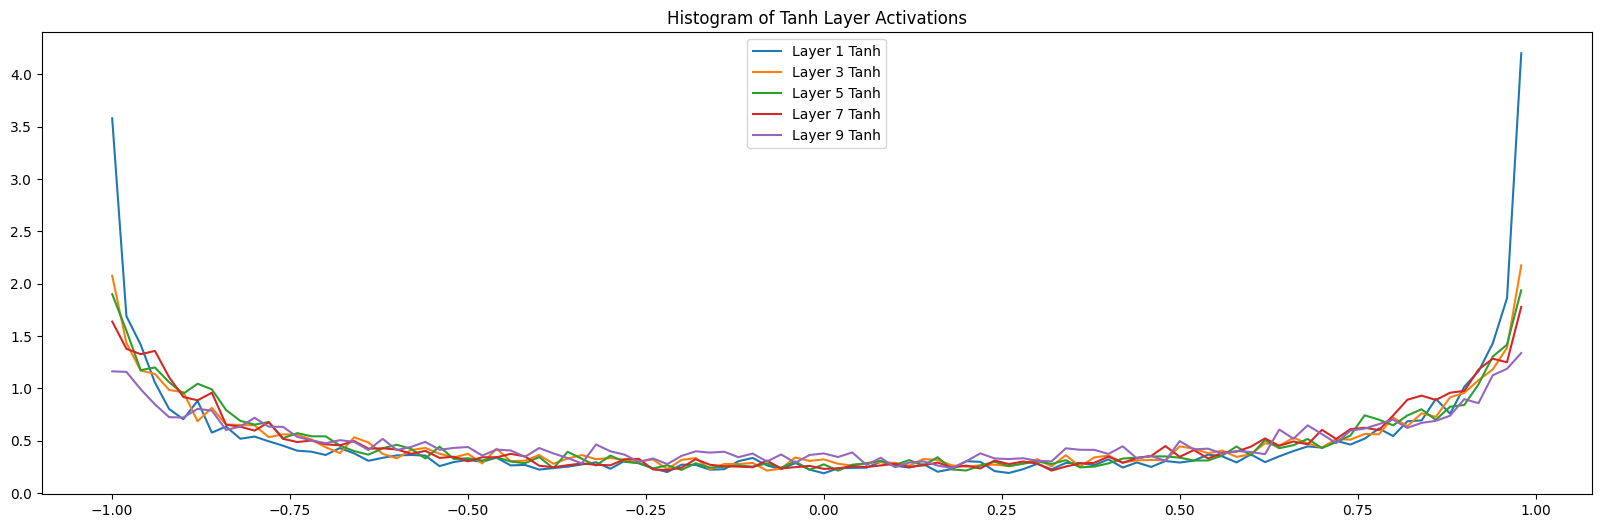

In [212]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_nobn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean():.2f}, Std: {t.std():.2f}, Saturations: {(((t.abs() > 0.97).sum() / t.numel()).item())*100.00:.2f}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Activations')
plt.legend(legends);
plt.show()

#### Plot if the gain of 1 is used 

In this we will squish to very uniform distribution

Layer 1: Tanh, Mean: 0.02, Std: 0.62, Saturations: 3.35
Layer 3: Tanh, Mean: -0.00, Std: 0.48, Saturations: 0.07
Layer 5: Tanh, Mean: -0.01, Std: 0.41, Saturations: 0.01
Layer 7: Tanh, Mean: -0.00, Std: 0.35, Saturations: 0.00
Layer 9: Tanh, Mean: 0.01, Std: 0.32, Saturations: 0.00


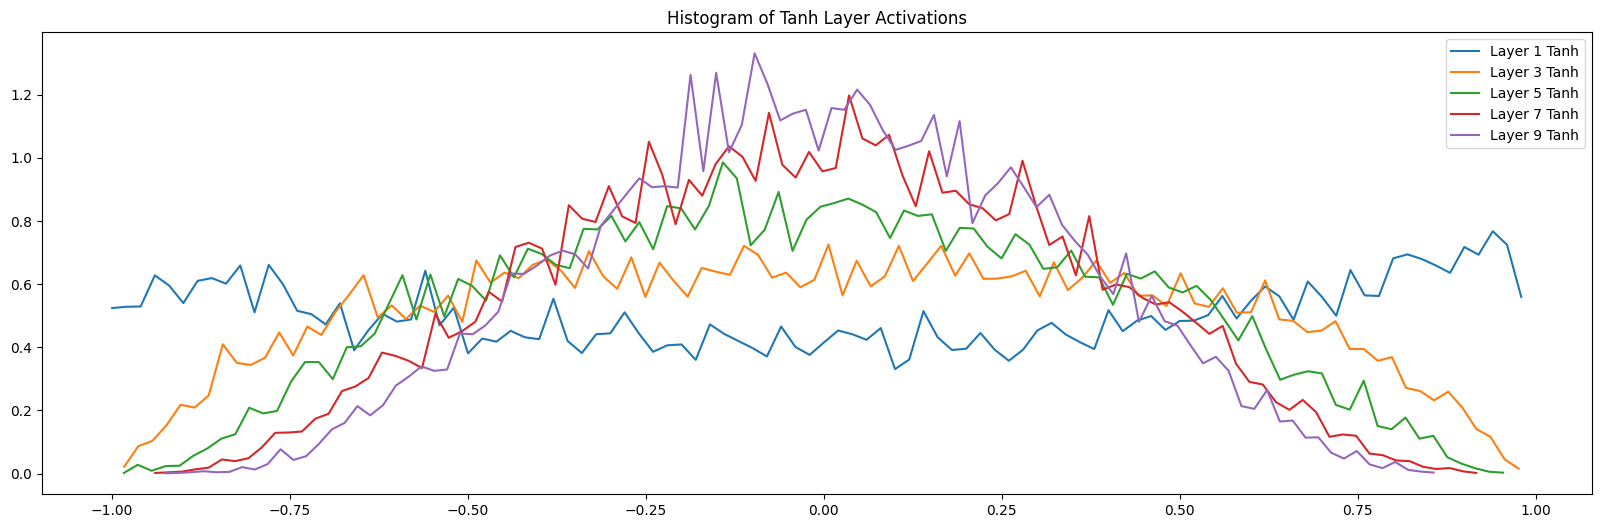

In [170]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_nobn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean():.2f}, Std: {t.std():.2f}, Saturations: {(((t.abs() > 0.97).sum() / t.numel()).item())*100.00:.2f}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Activations')
plt.legend(legends);
plt.show()

#### Very low gain of 0.5

Layer 1: Tanh, Mean: 0.01, Std: 0.41, Saturations: 0.01
Layer 3: Tanh, Mean: 0.00, Std: 0.19, Saturations: 0.00
Layer 5: Tanh, Mean: -0.00, Std: 0.10, Saturations: 0.00
Layer 7: Tanh, Mean: -0.00, Std: 0.05, Saturations: 0.00
Layer 9: Tanh, Mean: 0.00, Std: 0.02, Saturations: 0.00


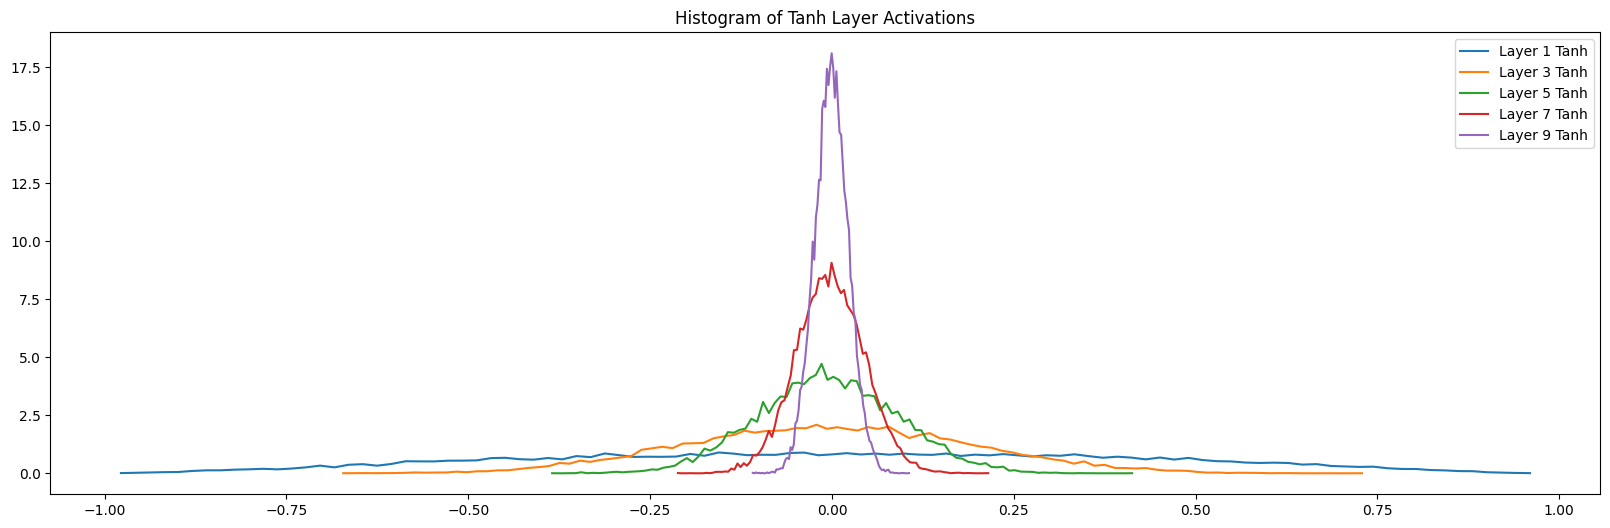

In [187]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_nobn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean():.2f}, Std: {t.std():.2f}, Saturations: {(((t.abs() > 0.97).sum() / t.numel()).item())*100.00:.2f}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Activations')
plt.legend(legends);
plt.show()

#### Very large gain of 3

Activations expand

Layer 1: Tanh, Mean: 0.03, Std: 0.86, Saturations: 46.31
Layer 3: Tanh, Mean: 0.00, Std: 0.84, Saturations: 41.79
Layer 5: Tanh, Mean: -0.02, Std: 0.84, Saturations: 41.43
Layer 7: Tanh, Mean: -0.00, Std: 0.84, Saturations: 40.05
Layer 9: Tanh, Mean: 0.02, Std: 0.84, Saturations: 40.68


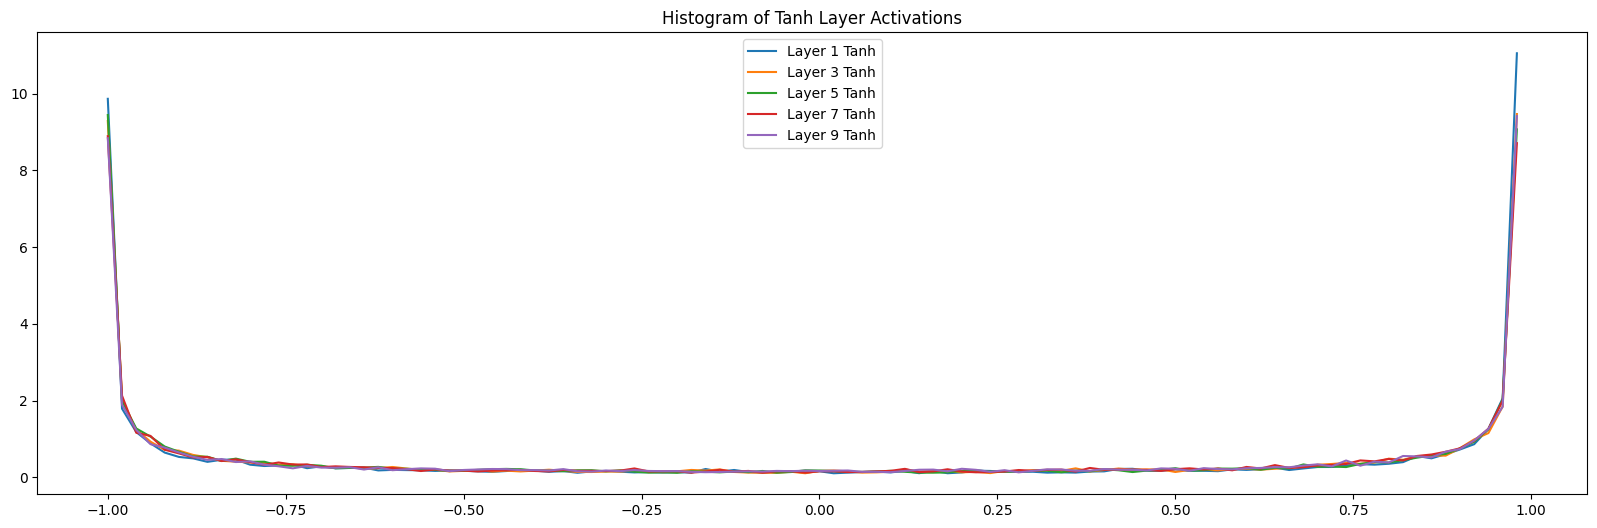

In [180]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_nobn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean():.2f}, Std: {t.std():.2f}, Saturations: {(((t.abs() > 0.97).sum() / t.numel()).item())*100.00:.2f}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Activations')
plt.legend(legends);
plt.show()

### Plot 2: Gradients of the tanh layer plotted as a histogram

#### With Kaiming init of 5/3

Gradients are neither exploding nor shrinking for any layer. And they have roughly the same distribution

Layer 1: Tanh, Mean: 3.344204344557511e-07, Std: 0.0003894410911016166
Layer 3: Tanh, Mean: -1.8624298263603123e-06, Std: 0.000365540967322886
Layer 5: Tanh, Mean: -9.481913139097742e-07, Std: 0.00035513221519067883
Layer 7: Tanh, Mean: 6.229163886928291e-07, Std: 0.0003394980158191174
Layer 9: Tanh, Mean: -4.255557541910093e-06, Std: 0.0002723001525737345


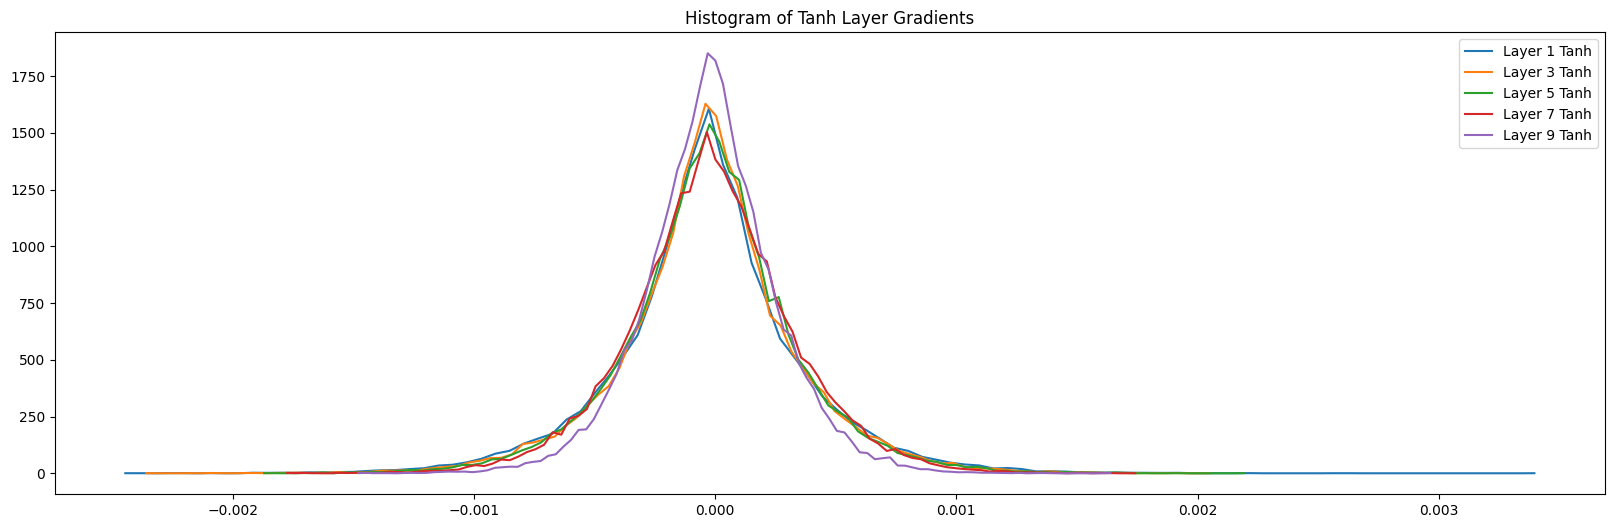

In [213]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_nobn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean()}, Std: {t.std()}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Gradients')
plt.legend(legends);
plt.show()

#### With gain of 1

Activations shrink --> gradients explode

Layer 1: Tanh, Mean: -2.7028346494262223e-07, Std: 2.109254819515627e-05
Layer 3: Tanh, Mean: 3.683019542677357e-07, Std: 2.6304151106160134e-05
Layer 5: Tanh, Mean: 6.129400986765177e-08, Std: 3.065330020035617e-05
Layer 7: Tanh, Mean: -4.256024794813129e-07, Std: 3.4839446016121656e-05
Layer 9: Tanh, Mean: -5.357332497624157e-07, Std: 3.799249680014327e-05


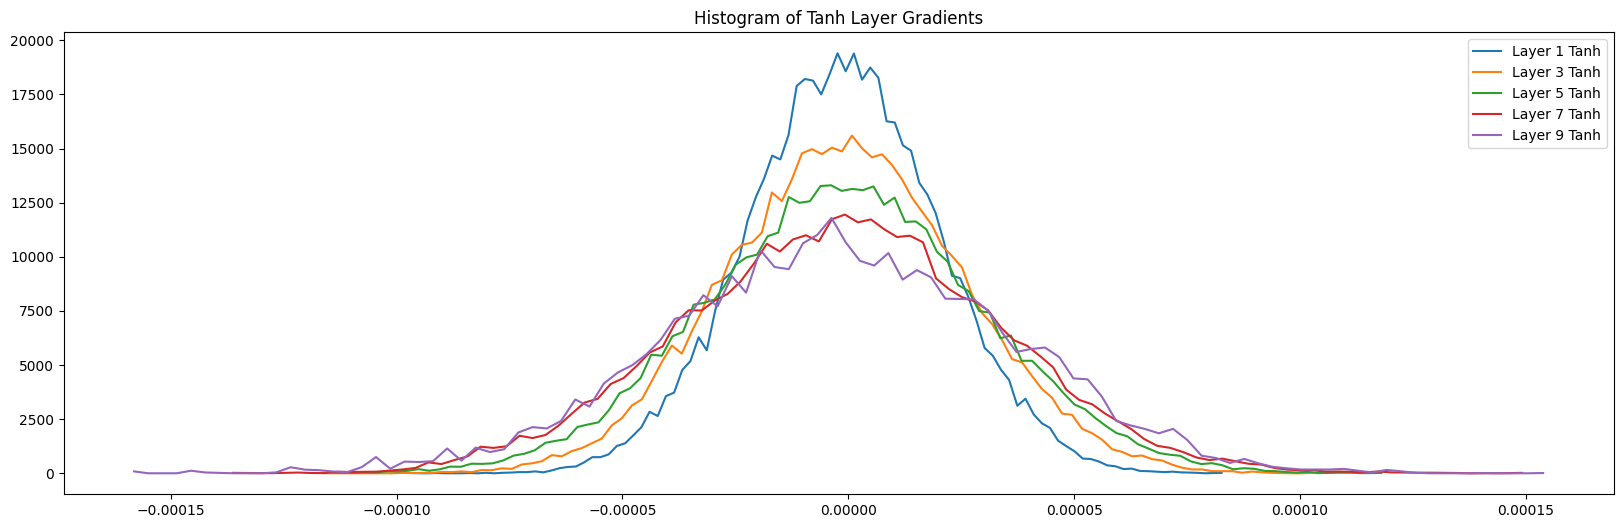

In [171]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_nobn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean()}, Std: {t.std()}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Gradients')
plt.legend(legends);
plt.show()

#### With gain of 3

Activations expand --> gradients shrink

Layer 1: Tanh, Mean: -3.292251733455487e-07, Std: 0.00012733494804706424
Layer 3: Tanh, Mean: -3.418784899622551e-07, Std: 9.613321890356019e-05
Layer 5: Tanh, Mean: 2.739343187840859e-07, Std: 7.352676038863137e-05
Layer 7: Tanh, Mean: 5.827795916957257e-07, Std: 5.366245022742078e-05
Layer 9: Tanh, Mean: 7.156289711929276e-07, Std: 3.898647628375329e-05


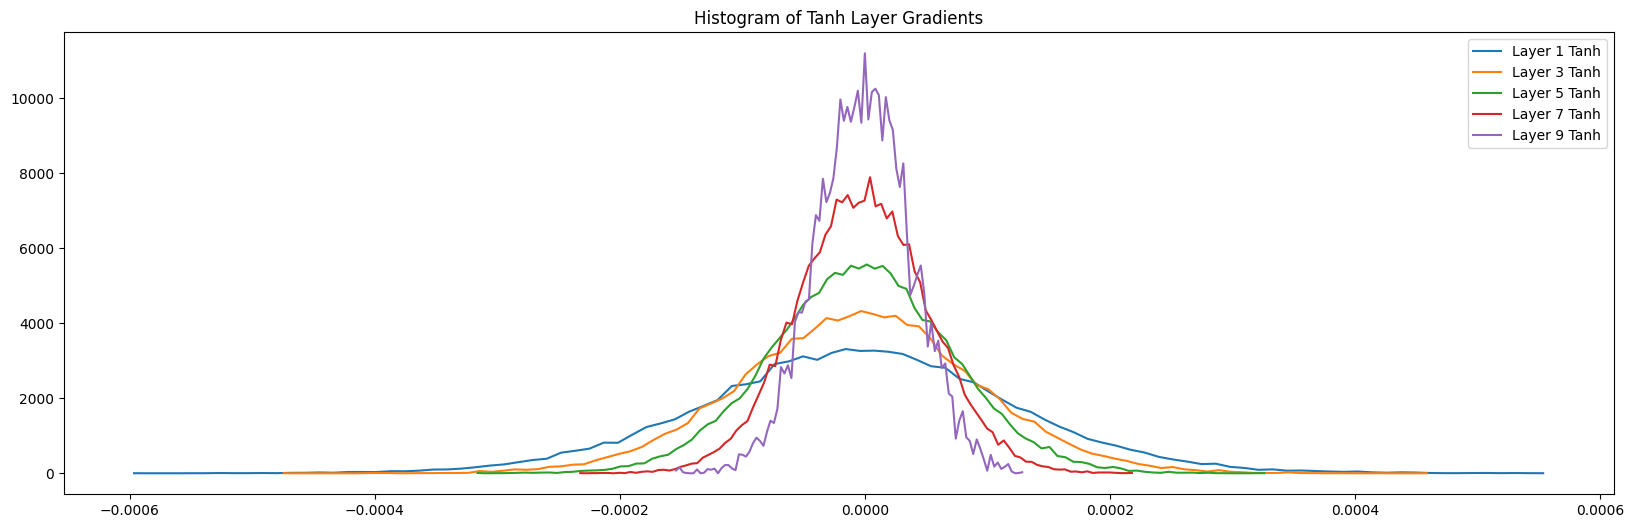

In [181]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_nobn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean()}, Std: {t.std()}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Gradients')
plt.legend(legends);
plt.show()

#### Gain 0.5

Activations shrink --> gradients expand

Layer 1: Tanh, Mean: 2.831030698757786e-08, Std: 2.337648311367957e-06
Layer 3: Tanh, Mean: -1.0350528434344142e-08, Std: 4.8256697482429445e-06
Layer 5: Tanh, Mean: 2.8262219231578456e-09, Std: 9.632855835661758e-06
Layer 7: Tanh, Mean: -2.20602018430327e-07, Std: 1.938430250447709e-05
Layer 9: Tanh, Mean: -7.119242013686744e-07, Std: 3.8489088183268905e-05


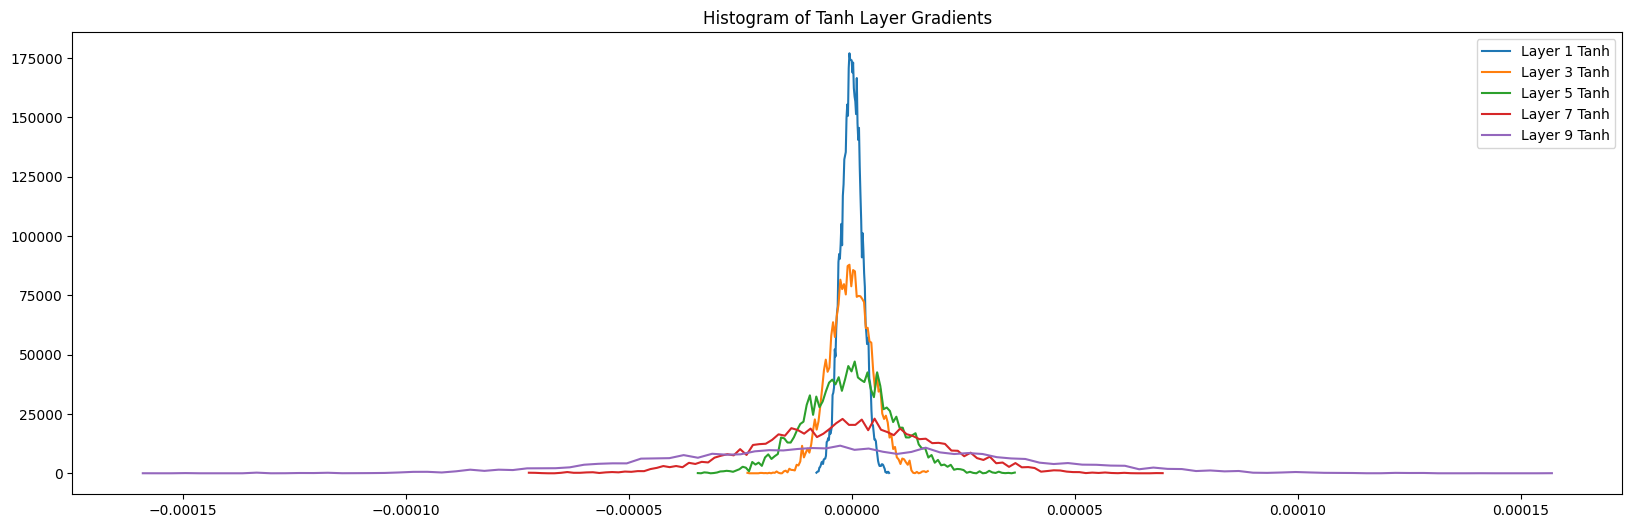

In [188]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_nobn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean()}, Std: {t.std()}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Gradients')
plt.legend(legends);
plt.show()

### Plot 3: Visualise gradients for all the parameters

Looks like the last layer trains much faster compared to the deeper layers

Param 0 torch.Size([27, 10]): Mean: 0.0001, Std: 6.09e-04
Param 1 torch.Size([30, 400]): Mean: 0.0000, Std: 3.39e-04
Param 2 torch.Size([400, 400]): Mean: -0.0000, Std: 2.88e-04
Param 3 torch.Size([400, 400]): Mean: 0.0000, Std: 2.61e-04
Param 4 torch.Size([400, 400]): Mean: 0.0000, Std: 2.47e-04
Param 5 torch.Size([400, 400]): Mean: -0.0000, Std: 2.28e-04
Param 6 torch.Size([400, 27]): Mean: -0.0000, Std: 1.29e-02


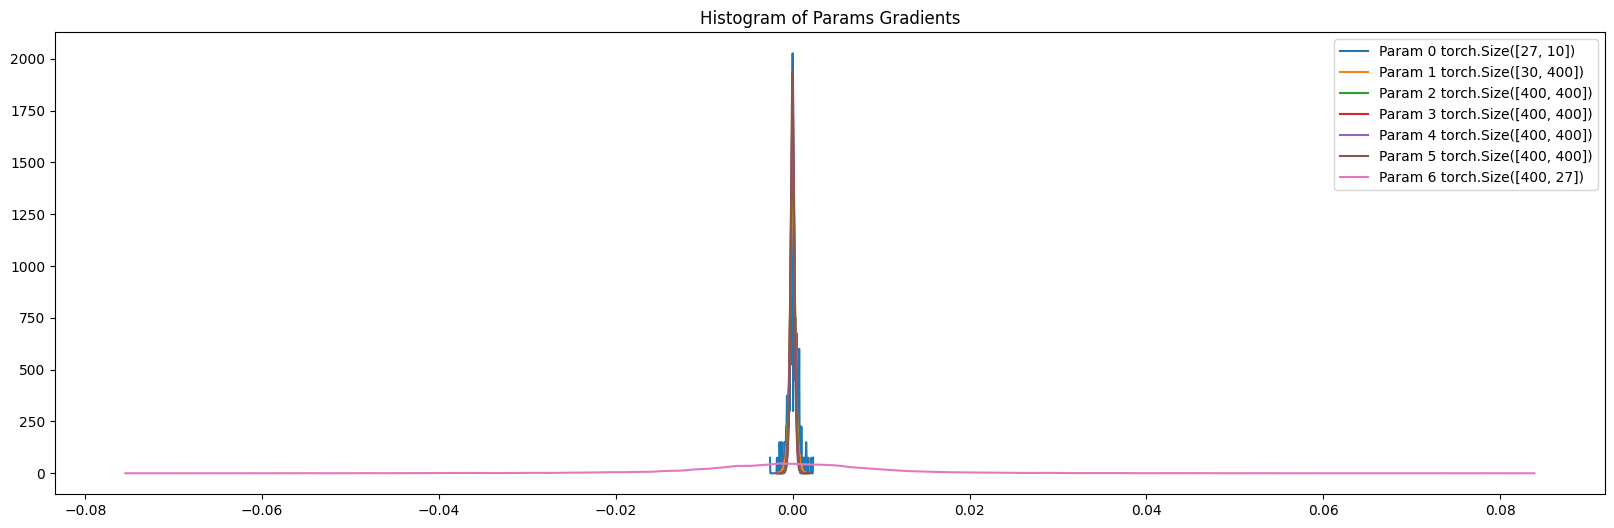

In [208]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params_nobn):
    if param.ndim == 2:
        t = param.grad
        print(f"Param {i} {param.shape}: Mean: {t.mean():.4f}, Std: {t.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Param {i} {param.shape}")

plt.title('Histogram of Params Gradients')
plt.legend(legends);
plt.show()

Solved after a few iterations

Param 0 torch.Size([27, 10]): Mean: 0.0001, Std: 3.16e-03
Param 1 torch.Size([30, 400]): Mean: 0.0000, Std: 9.85e-04
Param 2 torch.Size([400, 400]): Mean: 0.0000, Std: 7.92e-04
Param 3 torch.Size([400, 400]): Mean: -0.0000, Std: 6.57e-04
Param 4 torch.Size([400, 400]): Mean: 0.0000, Std: 5.36e-04
Param 5 torch.Size([400, 400]): Mean: -0.0000, Std: 3.90e-04
Param 6 torch.Size([400, 27]): Mean: 0.0000, Std: 1.16e-02


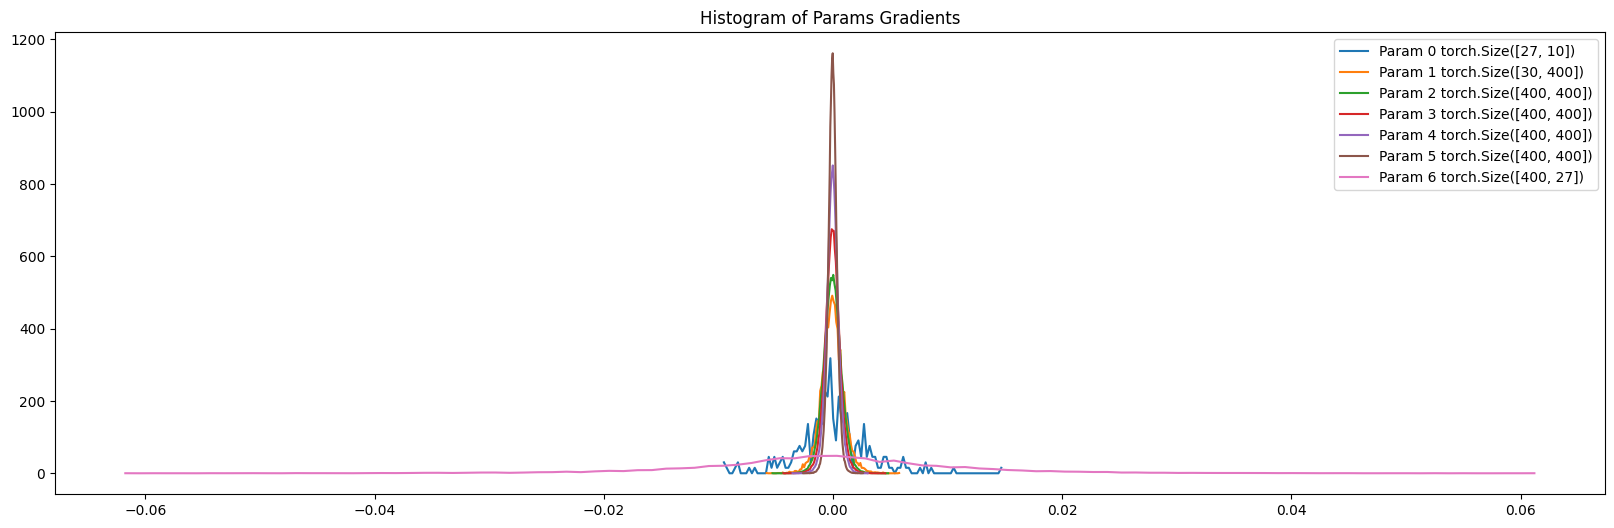

In [230]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params_nobn):
    if param.ndim == 2:
        t = param.grad
        print(f"Param {i} {param.shape}: Mean: {t.mean():.4f}, Std: {t.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Param {i} {param.shape}")

plt.title('Histogram of Params Gradients')
plt.legend(legends);
plt.show()

### Plot 4: Gradient update per param

In [224]:
ud.shape

torch.Size([1000, 8])

Last layer training faster, need to reduce lr

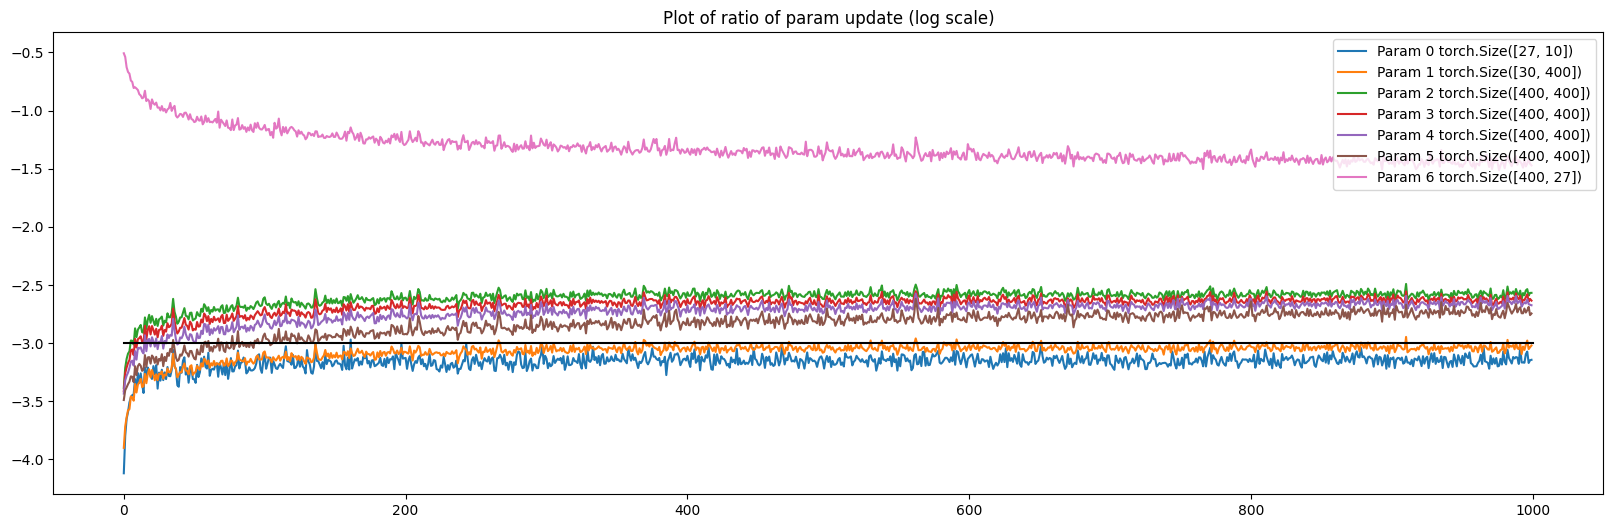

In [288]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params_nobn):
    if param.ndim == 2:
        plt.plot(stepi, ud[:, i])
        legends.append(f"Param {i} {param.shape}")

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.title('Plot of ratio of param update (log scale)')
plt.legend(legends);
plt.show()

lr = 0.001

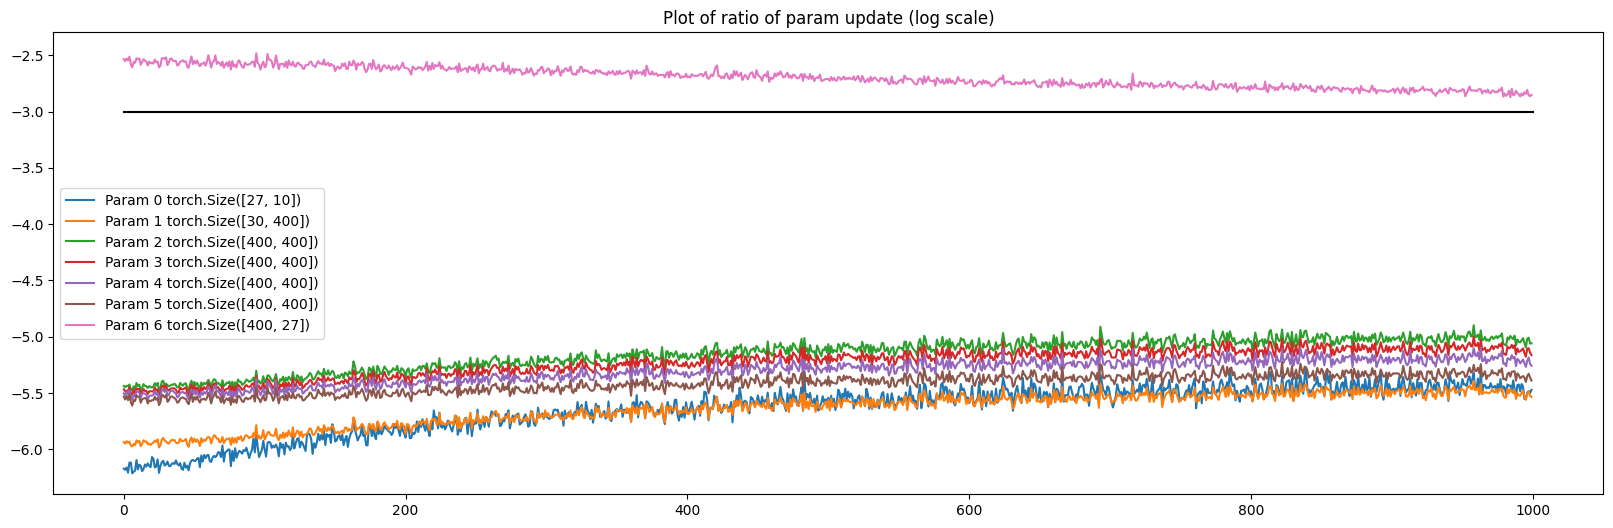

In [283]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params_nobn):
    if param.ndim == 2:
        plt.plot(stepi, ud[:, i])
        legends.append(f"Param {i} {param.shape}")

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.title('Plot of ratio of param update (log scale)')
plt.legend(legends);
plt.show()

### Introduce back BatchNorm

In [316]:
def create_model(vocab_size, block_size, emb_dim, hidden_dim):
    g = torch.Generator().manual_seed(2147483647)

    # create embeddimg matrix
    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

    # build the full network
    # layers = [
    #     Linear(emb_dim * block_size, hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
    #     Linear(hidden_dim , hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
    #     Linear(hidden_dim , hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
    #     Linear(hidden_dim , vocab_size)
    # ]

    layers = [
        Linear(emb_dim * block_size, hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
        Linear(hidden_dim , hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
        Linear(hidden_dim , hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
        Linear(hidden_dim , hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
        Linear(hidden_dim , hidden_dim, generator=g, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
        Linear(hidden_dim , vocab_size, bias=False), BatchNorm1d(vocab_size, momentum=0.005),
    ]

    with torch.no_grad():
        # Make last layer activations bit unconfident
        layers[-1].scale.data *= 0.1

        # Do Kaiming init for the remaning layers
        for layer in layers[:-2]:
            if isinstance(layer, Linear):
                layer.weights.data *= 5/3

    params = [C] + [param for layer in layers for param in layer.params()]

    for p in params:
        p.requires_grad = True

    print(f"No. of parameters = {sum(p.numel() for p in params)}")

    return params, layers

In [329]:
params_bn, layers_bn = create_model(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi))

No. of parameters = 667124


In [330]:
stepi, lossi, ud= train(learning_rate_schedule=lambda i: (10**(-1.0)) if i < 100000 else (10**(-2.0)),\
                            num_iters=1000, params=params_bn, layers=layers_bn,\
                                X=X_train, y=y_train, batch_size=128)

Step 0, Loss 3.3157403469085693


#### Activations

Layer 2: Tanh, Mean: 0.00, Std: 0.63, Saturations: 3.24
Layer 5: Tanh, Mean: -0.00, Std: 0.64, Saturations: 2.93
Layer 8: Tanh, Mean: -0.00, Std: 0.64, Saturations: 2.88
Layer 11: Tanh, Mean: 0.00, Std: 0.64, Saturations: 2.79
Layer 14: Tanh, Mean: 0.00, Std: 0.64, Saturations: 2.89


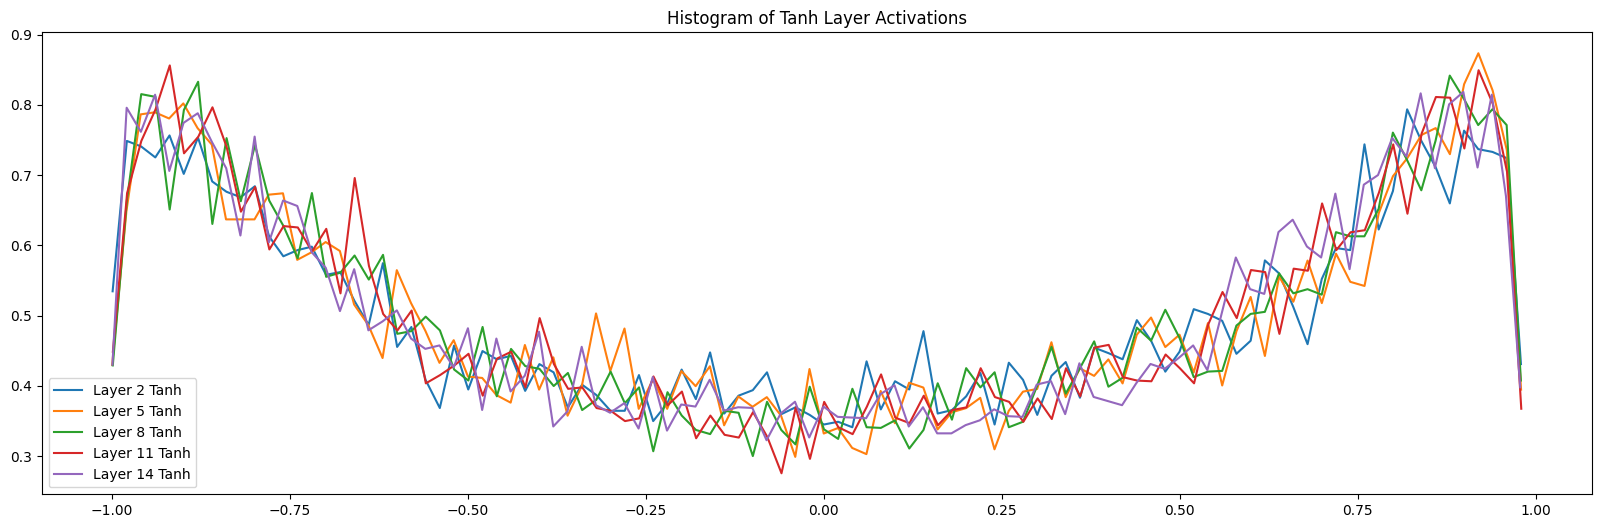

In [331]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_bn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean():.2f}, Std: {t.std():.2f}, Saturations: {(((t.abs() > 0.97).sum() / t.numel()).item())*100.00:.2f}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Activations')
plt.legend(legends);
plt.show()

#### Gradients

Layer 2: Tanh, Mean: -2.18278723546593e-13, Std: 0.00042853978811763227
Layer 5: Tanh, Mean: 4.547473508864641e-13, Std: 0.0003783537831623107
Layer 8: Tanh, Mean: -9.458744551493758e-13, Std: 0.00034999704803340137
Layer 11: Tanh, Mean: 2.91038298062124e-13, Std: 0.00031386411865241826
Layer 14: Tanh, Mean: -3.63797872577655e-14, Std: 0.0002782343071885407


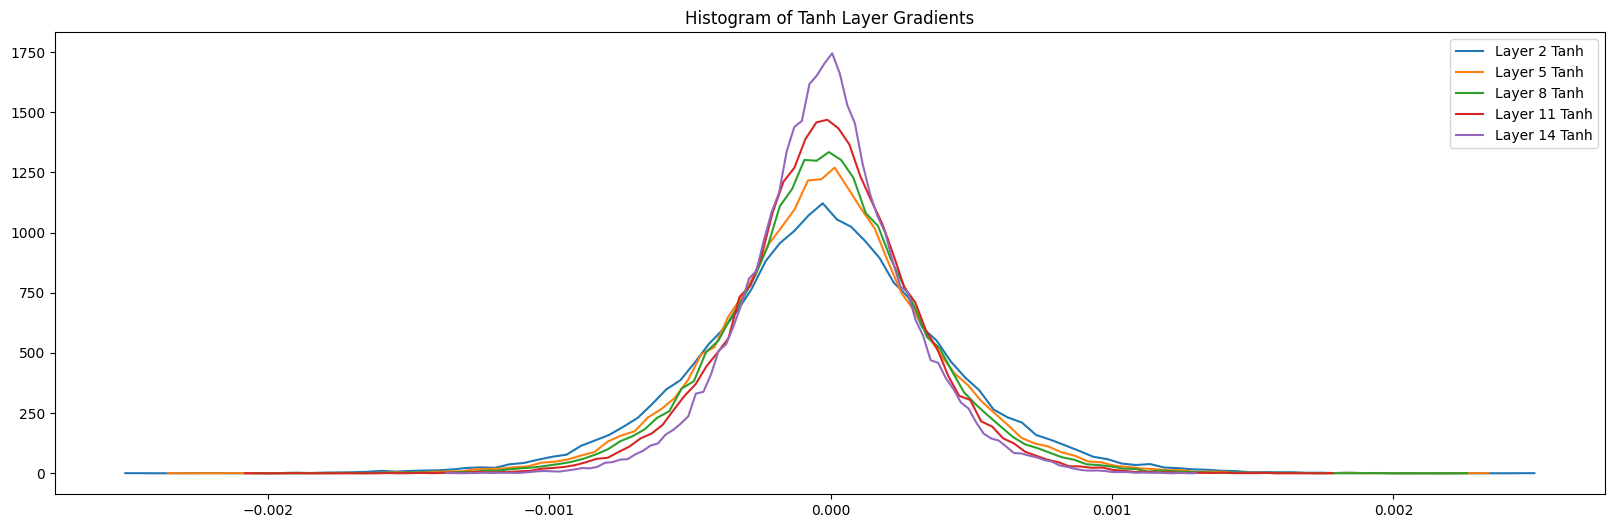

In [332]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_bn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean()}, Std: {t.std()}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Gradients')
plt.legend(legends);
plt.show()

#### Gradients of all params

Param 0 torch.Size([27, 10]): Mean: 0.0000, Std: 4.93e-03
Param 1 torch.Size([30, 400]): Mean: 0.0000, Std: 2.04e-03
Param 4 torch.Size([400, 400]): Mean: -0.0000, Std: 1.78e-03
Param 7 torch.Size([400, 400]): Mean: 0.0000, Std: 1.60e-03
Param 10 torch.Size([400, 400]): Mean: -0.0000, Std: 1.43e-03
Param 13 torch.Size([400, 400]): Mean: -0.0000, Std: 1.26e-03
Param 16 torch.Size([400, 27]): Mean: 0.0000, Std: 6.61e-03


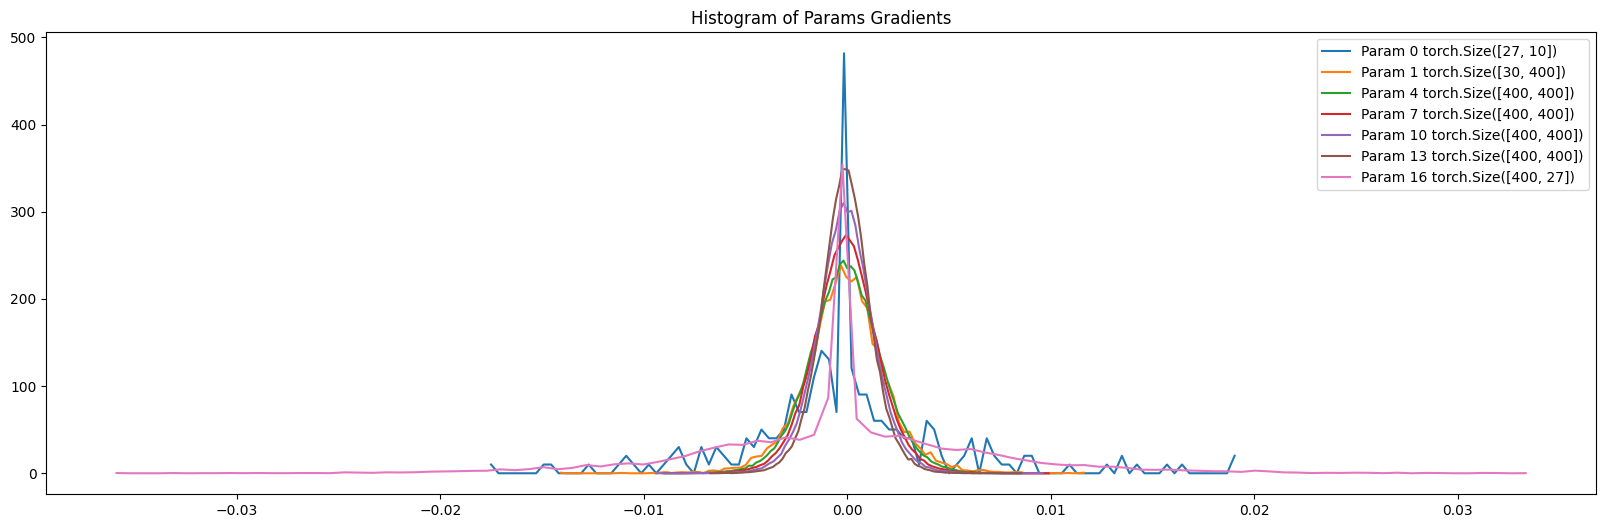

In [333]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params_bn):
    if param.ndim == 2 and param.shape[0]!=1:
        t = param.grad
        print(f"Param {i} {param.shape}: Mean: {t.mean():.4f}, Std: {t.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Param {i} {param.shape}")

plt.title('Histogram of Params Gradients')
plt.legend(legends);
plt.show()

#### Update ratio of the params

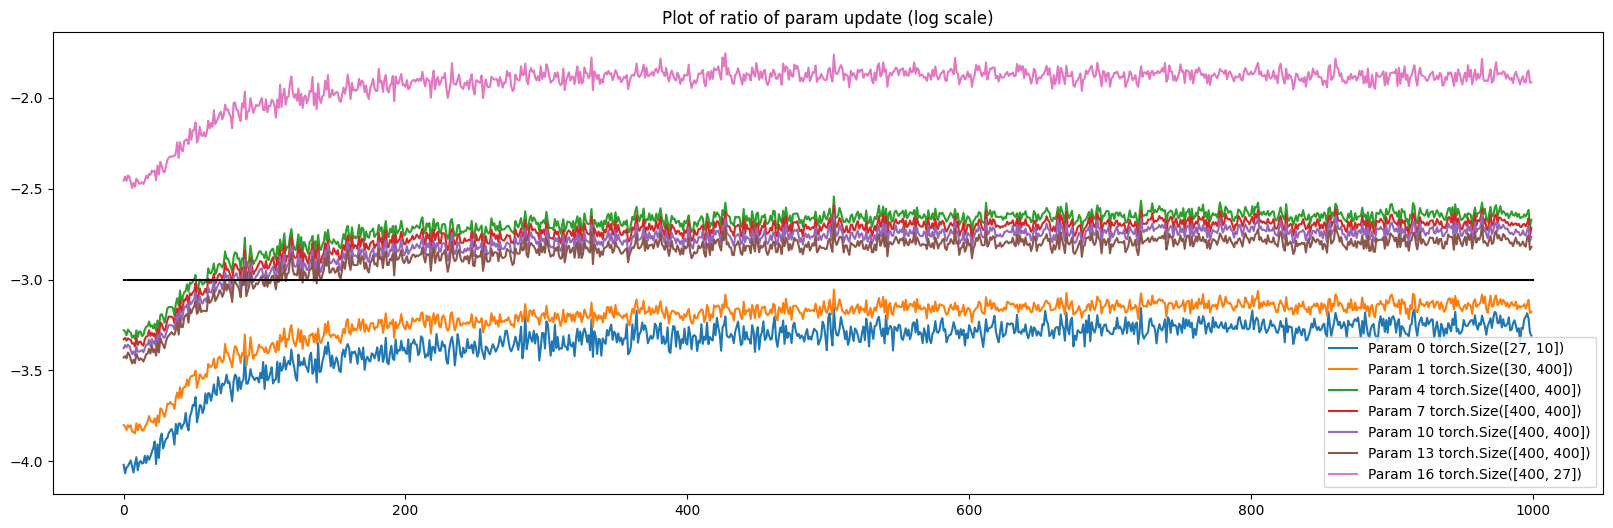

In [334]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params_bn):
    if param.ndim == 2 and param.shape[0]!=1:
        plt.plot(stepi, ud[:, i])
        legends.append(f"Param {i} {param.shape}")

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.title('Plot of ratio of param update (log scale)')
plt.legend(legends);
plt.show()

## Train for all epochs and sample

In [372]:
params_bn, layers_bn = create_model(emb_dim=10, hidden_dim=400, block_size=3,\
                                 vocab_size=len(stoi))

No. of parameters = 667124


In [373]:
stepi, lossi, ud= train(learning_rate_schedule=lambda i: (10**(-1.0)) if i < 100000 else (10**(-2.0)),\
                            num_iters=200000, params=params_bn, layers=layers_bn,\
                                X=X_train, y=y_train, batch_size=128)

Step 0, Loss 3.291952610015869
Step 10000, Loss 2.0273473262786865
Step 20000, Loss 2.0401110649108887
Step 30000, Loss 2.0959055423736572
Step 40000, Loss 2.0268945693969727
Step 50000, Loss 2.0926506519317627
Step 60000, Loss 2.0430748462677
Step 70000, Loss 2.002666711807251
Step 80000, Loss 1.7889585494995117
Step 90000, Loss 1.9852102994918823
Step 100000, Loss 2.0020737648010254
Step 110000, Loss 2.028900384902954
Step 120000, Loss 1.8018513917922974
Step 130000, Loss 1.9200721979141235
Step 140000, Loss 1.7173259258270264
Step 150000, Loss 1.800697922706604
Step 160000, Loss 2.1047143936157227
Step 170000, Loss 2.008572578430176
Step 180000, Loss 1.9418134689331055
Step 190000, Loss 1.6438236236572266


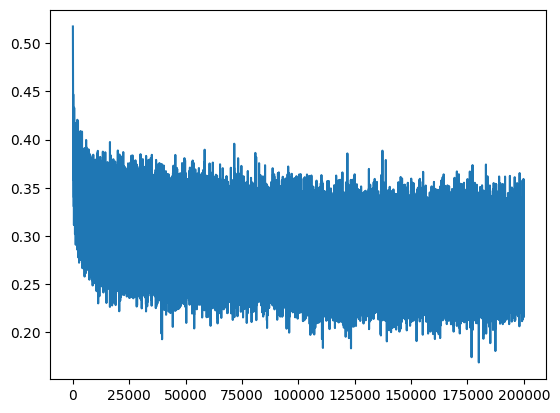

In [374]:
plt.plot(stepi, lossi)

In [375]:
@torch.no_grad()
def compute_loss(params, layers, X, y):
    emb = params[0][X]
    h = emb.view(X.shape[0], -1)
    for layer in layers:
        h = layer(h)
    logits = h
    return torch.nn.functional.cross_entropy(logits, y).item()

In [376]:
train_loss = compute_loss(params_bn, layers_bn, X_train, y_train)
val_loss = compute_loss(params_bn, layers_bn, X_val, y_val)
train_loss, val_loss

(1.8942598104476929, 2.0888612270355225)

Layer 2: Tanh, Mean: 0.02, Std: 0.73, Saturations: 14.75
Layer 5: Tanh, Mean: -0.03, Std: 0.70, Saturations: 13.50
Layer 8: Tanh, Mean: 0.04, Std: 0.72, Saturations: 9.50
Layer 11: Tanh, Mean: 0.04, Std: 0.72, Saturations: 11.25
Layer 14: Tanh, Mean: -0.03, Std: 0.72, Saturations: 12.25


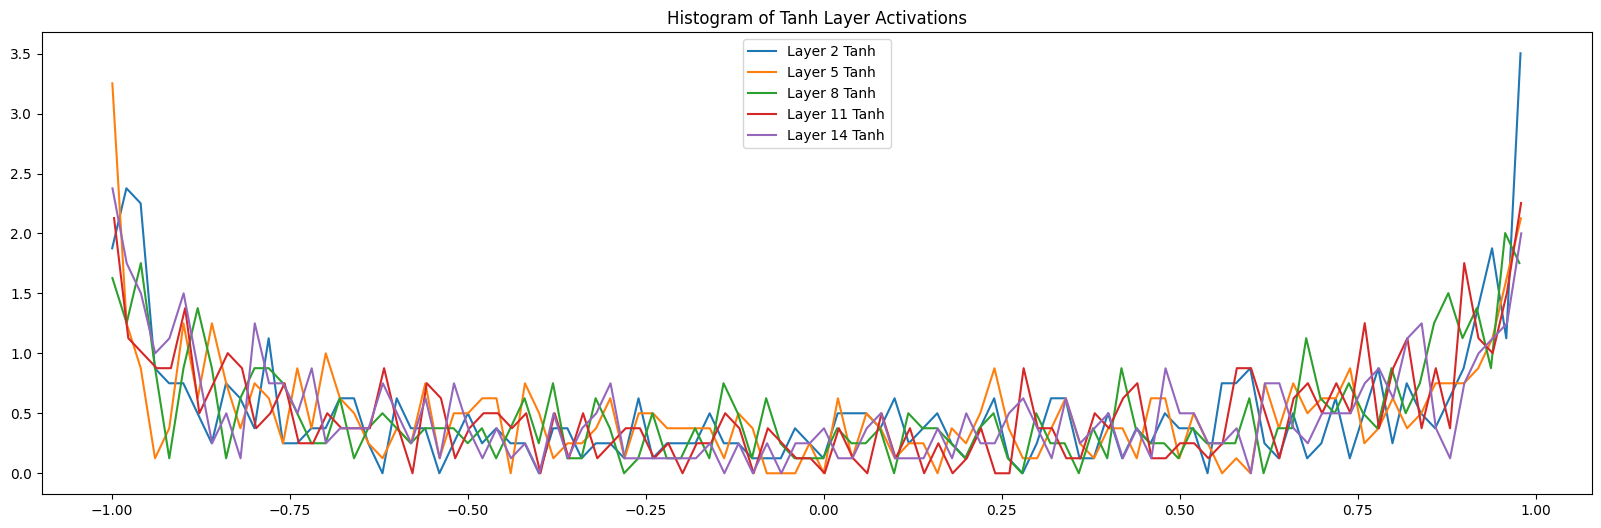

In [393]:
# Plot activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, layer in enumerate(layers_bn[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: {layer.__class__.__name__}, Mean: {t.mean():.2f}, Std: {t.std():.2f}, Saturations: {(((t.abs() > 0.97).sum() / t.numel()).item())*100.00:.2f}")        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.title('Histogram of Tanh Layer Activations')
plt.legend(legends);
plt.show()

Param 0 torch.Size([27, 10]): Mean: -0.0000, Std: 6.61e-03
Param 1 torch.Size([30, 400]): Mean: 0.0000, Std: 2.58e-03
Param 4 torch.Size([400, 400]): Mean: -0.0000, Std: 1.60e-03
Param 7 torch.Size([400, 400]): Mean: -0.0000, Std: 1.62e-03
Param 10 torch.Size([400, 400]): Mean: 0.0000, Std: 1.54e-03
Param 13 torch.Size([400, 400]): Mean: 0.0000, Std: 1.32e-03
Param 16 torch.Size([400, 27]): Mean: 0.0000, Std: 4.07e-03


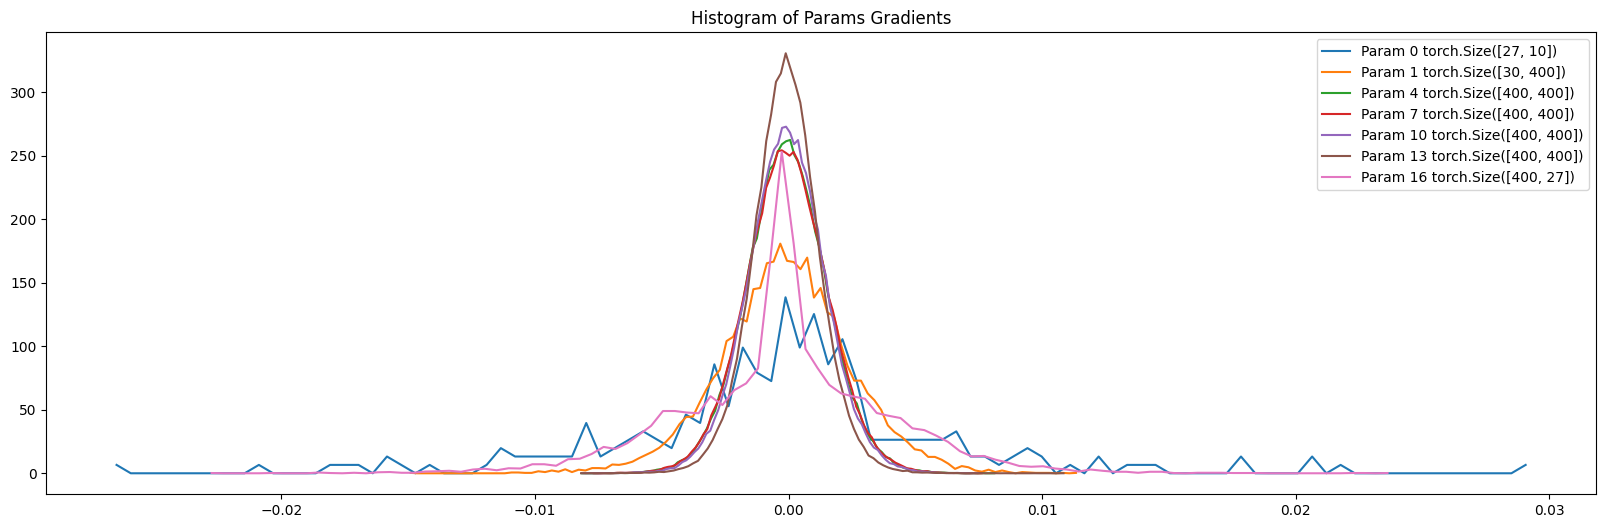

In [394]:
# Collect activations from the Tanh layers
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params_bn):
    if param.ndim == 2 and param.shape[0]!=1:
        t = param.grad
        print(f"Param {i} {param.shape}: Mean: {t.mean():.4f}, Std: {t.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"Param {i} {param.shape}")

plt.title('Histogram of Params Gradients')
plt.legend(legends);
plt.show()

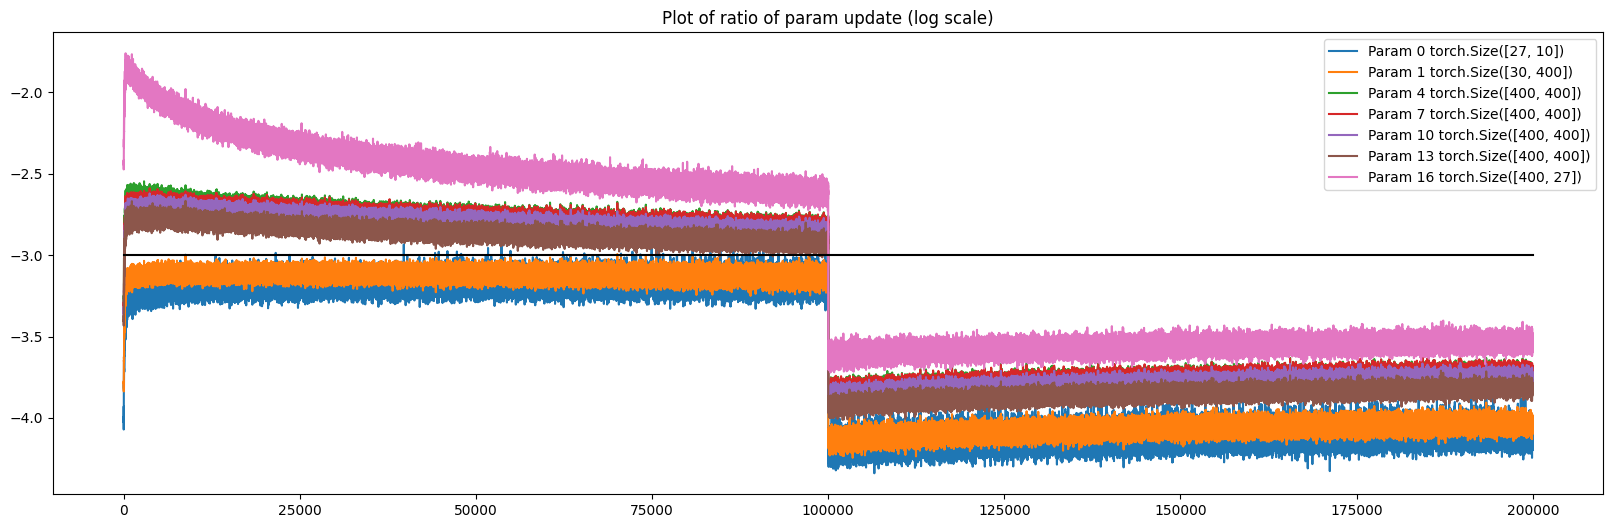

In [395]:
plt.figure(figsize=(20, 6))
legends = []

for i, param in enumerate(params_bn):
    if param.ndim == 2 and param.shape[0]!=1:
        plt.plot(stepi, ud[:, i])
        legends.append(f"Param {i} {param.shape}")

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.title('Plot of ratio of param update (log scale)')
plt.legend(legends);
plt.show()

In [396]:
test_loss = compute_loss(params_bn, layers_bn, X_test, y_test)
test_loss

2.0943522453308105

### Sample

In [399]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 20)

for _ in range(20):
    
    out = []
    context = [0] * 3 # initialize with all ...
    while True:
      # forward pass the neural net
      emb = params_bn[0][torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
    #   print(x.shape, emb.shape)
      for layer in layers_bn:
        x = layer(x)
      logits = x
      probs = torch.nn.functional.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

rashames.
savontarisa.
majid.
mehni.
kelsiel.
aldon.
cylen.
jenav.
malaithan.
abigan.
aun.
xail.
ivonnisharie.
anna.
rayne.
eva.
ward.
macaiel.
daryott.
camalaniiah.
